## The Low Level Problem

Given a Directed Acyclic Graph write a tested program to accomplish the following:
1. Print the vertex (V) reachable by the greatest number of paths from the source vertex 0.
2. Sort and print those paths according to their cost (descending).
3. Introduce an additional vertex (V`) that satisfies the following conditions:

        a. V` is now the most reachable vertex (instead of V).
        b. None of the vertices which share an edge with V share an edge with V`.
4. If (3.b) is impossible, display an error message explaining why.
5. If (3) succeeds, print V`’s insertion in the input format.

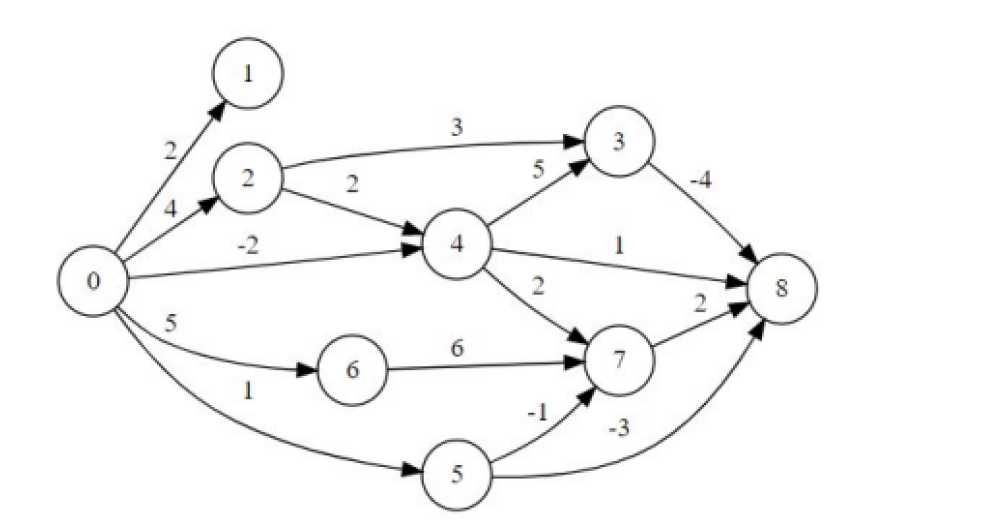

In [10]:
from collections import defaultdict, deque

class DAGSolver:
    def __init__(self, edges, source):
        # Initialize data structures:
        self.graph = defaultdict(list)  # Dictionary to store the graph: {node: [(neighbor, cost), ...]}
        self.in_degree = defaultdict(int)  # Dictionary to count incoming edges for each node (in-degree)
        self.paths_to = defaultdict(int)  # Dictionary to count paths reaching each node from the source
        self.costs = defaultdict(list)  # Dictionary to store accumulated costs of all paths reaching each node
        self.source = source  # Source node (0 in this case)
        self.vertices = set()  # Set to store all unique nodes

        # Build the graph from the list of edges
        for u, v, w in edges:
            self.graph[u].append((v, w))  # Add an edge from u to v with cost w
            self.in_degree[v] += 1  # Increment the in-degree of v
            self.vertices.update([u, v])  # Add u and v to the set of nodes

        # Sort nodes for processing
        self.vertices = sorted(self.vertices)
        # Calculate topological order of the graph (important for processing nodes in dependency order)
        self.topological_order = self.topological_sort()
        
    def topological_sort(self):
        # Make a copy of the in-degree dictionary to avoid modifying the original
        in_degree = self.in_degree.copy()
        # Queue for nodes with in-degree 0 (start with the source)
        queue = deque([self.source])
        order = []  # List to store the topological order
        
        # While the queue is not empty
        while queue:
            u = queue.popleft()  # Get the first node from the queue
            order.append(u)  # Add it to the topological order
            # Process all neighbors of u
            for v, w in self.graph[u]:
                in_degree[v] -= 1  # Decrement the in-degree of neighbor v
                if in_degree[v] == 0:  # If v now has in-degree 0, add it to the queue
                    queue.append(v)
        return order  # Return the topological order
    
    def compute_paths_and_costs(self):
        # Initialize the source node: 1 path to itself with cost 0
        self.paths_to[self.source] = 1
        self.costs[self.source] = [0]
        
        # Process all nodes in topological order
        for u in self.topological_order:
            # For each neighbor v of u, with edge cost w
            for v, w in self.graph[u]:
                # Number of paths to v is the sum of paths to its predecessors
                self.paths_to[v] += self.paths_to[u]
                # For each accumulated cost to u, add the cost to v (accumulated_cost_u + w)
                for cost in self.costs[u]:
                    self.costs[v].append(cost + w)
    
    def get_most_reachable_vertex(self):
        max_paths = -1
        candidate = None
        # Find the node (excluding source) with the most paths reaching it
        for v in self.vertices:
            if v != self.source and self.paths_to[v] > max_paths:
                max_paths = self.paths_to[v]
                candidate = v
        return candidate  # Return that node
    
    def get_costs_to_vertex(self, v):
        # Return costs of paths to v, sorted in descending order
        return sorted(self.costs[v], reverse=True)
    
    def get_neighbors_of(self, v):
        # Return direct neighbors of v (nodes that v points to)
        return set([neighbor for neighbor, w in self.graph[v]])

    def get_neighbors_to(self, v):
        # Return all nodes that have an edge pointing to v
        incoming_neighbors = set()
        for u in self.graph:
            for neighbor, w in self.graph[u]:
                if neighbor == v:
                    incoming_neighbors.add(u)
        return incoming_neighbors
    
    def find_all_paths_to_vertex(self, target):
        """
        Find all paths from the source (0) to the target vertex.
        Returns a list of paths, where each path is a list of vertices.
        """
        # Use DFS to find all paths
        all_paths = []
        stack = [(self.source, [self.source])]  # (current_node, current_path)
        
        while stack:
            current, path = stack.pop()
            if current == target:
                all_paths.append(path)
            else:
                for neighbor, w in self.graph[current]:
                    # Avoid cycles (though it's a DAG, just in case)
                    if neighbor not in path:
                        stack.append((neighbor, path + [neighbor]))
        return all_paths
    
    def add_vertex(self, v_star, edges_to_add):
        # Get the current most reachable vertex (V)
        v = self.get_most_reachable_vertex()
        # Get all nodes that point to V (incoming neighbors)
        v_neighbors = self.get_neighbors_to(v) 
        
        # Verify that no edge to V* comes from a node that points to V
        for u, w in edges_to_add:
            if u in v_neighbors:
                return False, "Condition 3.b violated: Shared edge with V's neighbors"
            
        print("No conflict with condition 3.b: None of the vertices share an edge with V's neighbors")
        
        # Add the new edges to V*
        for u, w in edges_to_add:
            self.graph[u].append((v_star, w))  # Add edge from u to V* with cost w
            self.in_degree[v_star] += 1  # Increment in-degree of V*
        
        # Update vertices list and recalculate topological order and paths
        self.vertices.append(v_star)
        self.vertices = sorted(self.vertices)
        self.topological_order = self.topological_sort()
        
        # Reinitialize paths and costs to recalculate from scratch
        self.paths_to = defaultdict(int)
        self.costs = defaultdict(list)
        self.compute_paths_and_costs()
        
        # Check if V* is now the most reachable vertex
        new_most_reachable = self.get_most_reachable_vertex()
        if new_most_reachable == v_star:
            return True, "Success"
        else:
            return False, "Despite adding V*, it is not the most reachable vertex"


In [11]:
# Input data
edges = [
    (0, 1, 2), (0, 2, 4), (0, 4, -2), (0, 5, 1), (0, 6, 5),
    (2, 3, 3), (2, 4, 2), (3, 8, -4), (4, 3, 5), (4, 8, 1),
    (4, 7, 2), (5, 7, -1), (5, 8, -3), (6, 7, 6), (7, 8, 2)
]

# Create solver instance
solver = DAGSolver(edges, 0)
solver.compute_paths_and_costs()

print("=" * 50)
print("1. Vertex reachable by the greatest number of paths from source vertex 0")
print("Number of paths reaching each vertex:")
for v in solver.vertices:
    print(f"Paths to {v}: {solver.paths_to[v]}")

v = solver.get_most_reachable_vertex()
print(f"Most reachable vertex: {v}")
print(f"All paths to vertex {v}: {solver.find_all_paths_to_vertex(v)}")
print(f"Total number of paths to vertex {v}: {solver.paths_to[v]}")

print("=" * 50)
print("2. Path costs sorted in descending order:")
print(f"Costs of all paths to vertex {v}: {solver.get_costs_to_vertex(v)}")

print("=" * 50)
print("3. Introducing additional vertex V* with conditions:")
print("   a. V* becomes the most reachable vertex (instead of V)")
print("   b. No vertex that shares an edge with V shares an edge with V*")
print("4. If condition 3b is impossible, display error message")
print("5. If successful, print V*'s insertion in input format")

print(f"\nCondition 3b is possible - there are vertices that are not direct neighbors of {v}")
print(f"Nodes that point to vertex {v}: {solver.get_neighbors_to(v)}")
v_neighbors = solver.get_neighbors_to(v) 
candidates = set(solver.vertices) - v_neighbors - {v}
print(f"Candidate nodes for connections to V* (those not pointing to {v}): {candidates}")
print(f"Creating connections from {candidates} to new vertex 9")

# Create edges from all candidates to new vertex
edges_to_add = [(u, 1) for u in candidates]
success, message = solver.add_vertex(9, edges_to_add)

print(f"\nAll paths to new vertex 9: {solver.find_all_paths_to_vertex(9)}")

if success:
    print("Success! V* is now the most reachable vertex")
    print(f"New edges added: {edges_to_add}")
else:
    print(f"Error: {message}")

print("=" * 50)
print("Updated path counts to each vertex:")
for v in solver.vertices:
    print(f"Paths to vertex {v}: {solver.paths_to[v]}")

1. Vertex reachable by the greatest number of paths from source vertex 0
Number of paths reaching each vertex:
Paths to 0: 1
Paths to 1: 1
Paths to 2: 1
Paths to 3: 3
Paths to 4: 2
Paths to 5: 1
Paths to 6: 1
Paths to 7: 4
Paths to 8: 10
Most reachable vertex: 8
All paths to vertex 8: [[0, 6, 7, 8], [0, 5, 8], [0, 5, 7, 8], [0, 4, 7, 8], [0, 4, 8], [0, 4, 3, 8], [0, 2, 4, 7, 8], [0, 2, 4, 8], [0, 2, 4, 3, 8], [0, 2, 3, 8]]
Total number of paths to vertex 8: 10
2. Path costs sorted in descending order:
Costs of all paths to vertex 8: [13, 10, 7, 7, 3, 2, 2, -1, -1, -2]
3. Introducing additional vertex V* with conditions:
   a. V* becomes the most reachable vertex (instead of V)
   b. No vertex that shares an edge with V shares an edge with V*
4. If condition 3b is impossible, display error message
5. If successful, print V*'s insertion in input format

Condition 3b is possible - there are vertices that are not direct neighbors of 8
Nodes that point to vertex 8: {3, 4, 5, 7}
Candidate no